# type 2 test influence diagram modelling validation

- create the code for the type 2 test
  
  

In [13]:
# enable autoreload of changes in accompanying code files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### necessary imports en settings

In [14]:
import os
import sys
import re
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from IPython.display import display, HTML, clear_output, Image
import pandas as pd
from itertools import product
import math
from deepdiff import DeepDiff

In [15]:
sys.path.insert(1, "/workspaces/ou-af/problem2/")

In [16]:
# import code
import src.oopnclasses as oopnclasses
import src.oopnbuilder as oopnbuilder
import src.diagrambuilder as diagrambuilder
import src.testobservereplace as testobservereplace
import src.testchangeinput as testchangeinput
import specs.components as componentspecs
import specs.connections as connectionspecs
import specs.assemblies as assemblyspecs
import specs.tests as testspecs

In [17]:
# Styling notebook
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML("<style>" + styles + "</style")

css_styling()

### methods to visualize diagram

In [18]:
def visualizeStructure(diagram):
#    display(HTML("<style>.container { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=60)
    
def createUtilityRow(nodelist):
    row_elements = [diagram.utility(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def createCptRow(nodelist):
    row_elements = [diagram.cpt(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def showCPTs(diagram):
    nodes = diagram.nodes()
    for n in nodes:
        if(diagram.isChanceNode(n)):
            gnb.flow.row(diagram.cpt(n))
            
def getDiagramChanceNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isChanceNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printCptTables(diagram, system):
    for component in system.getComponents():
        print("CPT tables for component: " + component.getName())
        createCptRow(getDiagramChanceNodeIdsForComponent(component.getName(), diagram))
        
def getDiagramUtilityNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isUtilityNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printUtilityTables(diagram, system):
    for component in system.getComponents():
        print("Utility tables for component: " + component.getName())
        createUtilityRow(getDiagramUtilityNodeIdsForComponent(component.getName(), diagram))

## generating influence diagram for a type 2 test

### loading system description

In [19]:
assembly = {
    "components"  : [componentspecs.light, componentspecs.switch],
    "connections" : [connectionspecs.wire, connectionspecs.wire2],
    "structure"   : assemblyspecs.structure1,   # light, switch en wire 
    "tests"       : [testspecs.observeorreplacetest, testspecs.changeinputtest],
    "testmapping" : testspecs.testmapping4     # geen testen want de test wordt hieronder handmatig toegevoegd
}

### generate OOPN

In [20]:
oopn = oopnbuilder.OopnBuilder(assembly).getOopn()

start building system: structure1
number of components: 2
number of connections: 1
number of tests: 0


In [21]:
# breid oopn uit door keten te dupliceren
oopn.copyPathType2Test('PresentPowerInputsSwitch', 'PresentLightOutputsLight')

adding component: Switchcopy
adding component: Lightcopy
adding connection Wirecopy between: Switchcopy and Lightcopy with healthnode: healthWire


### generate influence diagram from OOPN

In [22]:
# create diagram object en bouw influence diagram obv OOPN
diagram = gum.InfluenceDiagram()
diagram = diagrambuilder.diagramBuilder(diagram, oopn)

adding component: Light
adding component: Switch
adding component: Switchcopy
node not added, already exists in diagramEnabledStateInputsSwitch
node not added, already exists in diagramhealthSwitch
adding component: Lightcopy
node not added, already exists in diagramhealthLight
adding connection between: PresentPowerOutputsSwitch and: PresentPowerInputsLight
adding connection between: PresentPowerOutputsSwitchcopy and: PresentPowerInputsLightcopy
node not added, already exists in diagramhealthWire
adding cpt for component: Light
adding cpt for component: Switch
adding cpt for component: Switchcopy
adding cpt for component: Lightcopy
adding cpt for connection: Wire
adding cpt for connection: Wirecopy


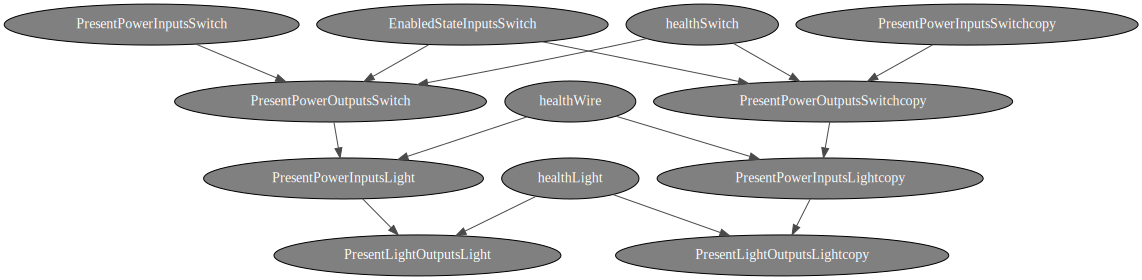

In [23]:
# tussenstand bekijken
gnb.showInfluenceDiagram(diagram, size=60)

### background variabelen: dupliceer keten door OOPN uit te breiden
- background variabelen: system en gedupliceerd systeem (behoud overige inputs en health)
- problem variabelen: health van iedere bij de keten betrokken component
- symptoom variabelen voor afwijkend gedrag: input / output van keten van componenten 


In [ ]:
# nieuw influence diagram genereren
diagram = gum.InfluenceDiagram()
diagram = diagrambuilder.diagramBuilder(diagram, oopn)

In [ ]:
gnb.showInfluenceDiagram(diagram, size=60)

In [ ]:
# Add mediating system health variabele
label = "systemhealth"
C1health = gum.LabelizedVariable(label, label,["ok", "broken"])
C1healthId = diagram.add(C1health)
diagram.addArc(diagram.idFromName("healthSwitch"), C1healthId)
diagram.addArc(diagram.idFromName("healthWire"), C1healthId)
diagram.addArc(diagram.idFromName("healthLight"), C1healthId)

In [ ]:
# creeer utility variabele
# detecter afwijkend gedrag: koppel input en output keten met utility
# koppel input gedupliceerde keten met utility

UtilityT2 = gum.LabelizedVariable("utilT2", "utilT2",1)
diagram.addUtilityNode(UtilityT2)
diagram.addArc("PresentPowerInputsSwitch", "utilT2")
#diagram.addArc("PresentLightOutputsLight", "utilT2")
diagram.addArc("PresentPowerInputsSwitchcopy", "utilT2")

In [ ]:
# creeer decision variabele
# conditioneel besluit, koppel output met decision
# intervenierend besluit, koppel besluit met input gedupliceerde keten
DecisionT2 = gum.LabelizedVariable("decT2", "decT2",["yes", "no"])
diagram.addDecisionNode(DecisionT2)
# diagram.addArc("PresentPowerInputsSwitch", "decT2")
diagram.addArc("PresentLightOutputsLight", "decT2")
diagram.addArc("decT2", "PresentPowerInputsSwitchcopy")

In [ ]:
diagram.addArc(diagram.idFromName("systemhealth"), diagram.idFromName("utilT2"))

In [ ]:
# complete influence diagram
gnb.showInfluenceDiagram(diagram, size=60)

### conditional probability table for system health

In [ ]:
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"ok", "healthWire":"ok", "healthSwitch":"ok"}] = [0.99, 0.01]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"ok", "healthWire":"ok", "healthSwitch":"broken"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"ok", "healthWire":"broken", "healthSwitch":"ok"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"ok", "healthWire":"broken", "healthSwitch":"broken"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"broken", "healthWire":"ok", "healthSwitch":"ok"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"broken", "healthWire":"ok", "healthSwitch":"broken"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"broken", "healthWire":"broken", "healthSwitch":"ok"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"broken", "healthWire":"broken", "healthSwitch":"broken"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))


### configuratie utility

In [ ]:
ok, broken = "ok", "broken"
yes, no = "yes", "no"
health, inputcopy, inputswitch = "systemhealth", "PresentPowerInputsSwitchcopy", "PresentPowerInputsSwitch"
id = diagram.idFromName("utilT2")
diagram.utility(id)[{health:ok,inputcopy:yes,inputswitch:yes}]     = 90  # indien ok dan zelfde input
diagram.utility(id)[{health:ok,inputcopy:yes,inputswitch:no}]      = -10 # indien health ok dan niet input wisselen
diagram.utility(id)[{health:ok,inputcopy:no,inputswitch:yes}]      = -10 # indien health ok dan niet input wisselen
diagram.utility(id)[{health:ok,inputcopy:no,inputswitch:no}]       = 90  # indien ok dan zelfde input
diagram.utility(id)[{health:broken,inputcopy:yes,inputswitch:yes}] = -50 # indien broken dan niet input gelijk houden
diagram.utility(id)[{health:broken,inputcopy:yes,inputswitch:no}]  = 100 # indien broken dan andere input
diagram.utility(id)[{health:broken,inputcopy:no,inputswitch:yes}]  = 100 # indien broken dan andere input
diagram.utility(id)[{health:broken,inputcopy:no,inputswitch:no}]   = -50


In [ ]:
diagram.utility(diagram.idFromName("utilT2"))

### uitbreiden cpt input van gedupliceerde keten

In [ ]:
diagram.cpt(diagram.idFromName("PresentPowerInputsSwitchcopy"))[1] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("PresentPowerInputsSwitchcopy"))

### Unit test 1, normaal gedrag > overnemen input

In [ ]:
evs = {
# input / output evidence van systeem, normaal gedrag is dus 0/0 of 1/1
'PresentPowerInputsSwitch':1,  # 0 is yes, 1 is no
'PresentLightOutputsLight':0,  # 0 is yes, 1 is no


# instellen additionele input
#'EnabledStateInputsSwitch':0,  # 0 is yes, 1 is no
}

In [ ]:
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))



wordt de juiste input voor de gedupliceerde keten ingesteld?
- indien evidence input / output systeem beide 0 (yes) dan wordt de input overgenomen voor de gedupliceerde keten
- indien evidence input / output systeem beide 1 (no) dan wordt de input overgenomen voor de gedupliceerde keten
- indien evidence input no en output yes dan wordt input voor gedupliceerde keten geswitched naar yes
- indien evidence input yes en output no dan wordt input voor gedupliceerde keten geswitched naar no 

laatste test gaat niet goed 


### OPNIEUW DOEN unit test 2, verwerken extra observatie, betere inschatting health?

In [ ]:
evs = {
# input / output evidence van systeem, normaal gedrag is 0/0 of 1/1
'PresentPowerInputsSwitch':0,  # 0 is yes, 1 is no
'PresentLightOutputsLight':1,  # 0 is yes, 1 is no


# instellen additionele input
'EnabledStateInputsSwitch':0,  # 0 is yes, 1 is no
    
# instellen observaties mbt duplicate chain
'PresentPowerInputsSwitchcopy':1,  # 0 is yes, 1 is no
'PresentLightOutputsLightcopy':1,  # 0 is yes, 1 is no


}

In [ ]:
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))

- indien originele observatie switch:aan maar lamp:uit
- en extra observatie is: switch:uit en lamp: uit
- waarbij prior van alle healths 99% is

dan is de health zonder de extra observatie > daarna met de extra observatie
- healthSwitch: 85,45% > 83,27%
- healthWire: 72,40% > 83,27%
- healthLight: 84,88% > 82,77%

dus eerst is de wire de verdachte maar daarna de lamp al ligt het dan dichter bij elkaar

### OPNIEUW DOEN indien health van wire lager wordt...
- healht wire wordt 80%

health zonder observatie en daarna met...
- healthSwitch: 86,34% > 83,9%
- healthWire: 67,95% > 80,08%
- healthLight: 85,75% > 83,39%

### OPNIEUW DOEN indien health van light lager wordt

- healthSwitch: 85,92% > 83,89%
- healthWire: 73,29% > 83,89%
- healthLight: 81,94% > 79,52%

In [ ]:
diagram.cpt(diagram.idFromName("healthWire"))

## overbodig geworden

In [ ]:
printCptTables(diagram, oopn)

In [ ]:
diagram.cpt(diagram.idFromName("healthSwitch"))[0] = 0.9
diagram.cpt(diagram.idFromName("healthSwitch"))[1] = 0.1
diagram.cpt(diagram.idFromName("healthSwitch"))
diagram2.cpt(diagram2.idFromName("healthSwitch"))[0] = 0.9
diagram2.cpt(diagram2.idFromName("healthSwitch"))[1] = 0.1
diagram2.cpt(diagram2.idFromName("healthSwitch"))

In [ ]:
diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy"))[{"healthLight":"ok", "PresentPowerInputsLightcopy":"yes"}] = [0.99, 0.01]      # yes, no
diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy"))[{"healthLight":"broken", "PresentPowerInputsLightcopy":"yes"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy"))[{"healthLight":"ok", "PresentPowerInputsLightcopy":"no"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy"))[{"healthLight":"broken", "PresentPowerInputsLightcopy":"no"}] = [0.01, 0.99]

diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"yes", "healthSwitch":"ok", "EnabledStateInputsSwitch":"yes"}] = [0.99, 0.01]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"yes", "healthSwitch":"ok", "EnabledStateInputsSwitch":"no"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"yes", "healthSwitch":"broken", "EnabledStateInputsSwitch":"yes"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"yes", "healthSwitch":"broken", "EnabledStateInputsSwitch":"no"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"no", "healthSwitch":"ok", "EnabledStateInputsSwitch":"yes"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"no", "healthSwitch":"ok", "EnabledStateInputsSwitch":"no"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"no", "healthSwitch":"broken", "EnabledStateInputsSwitch":"yes"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"no", "healthSwitch":"broken", "EnabledStateInputsSwitch":"no"}] = [0.01, 0.99]



In [ ]:
'''
# normaal gedrag
a, b, c = "yes", "yes", "yes"
dict = {"PresentPowerInputsSwitch":a, "PresentLightOutputsLight":b, "PresentPowerInputsSwitchcopy":c}
diagram.utility(diagram.idFromName("utilT2"))[dict] = 100

a, b, c = "no", "no", "no"
dict = {"PresentPowerInputsSwitch":a, "PresentLightOutputsLight":b, "PresentPowerInputsSwitchcopy":c}
diagram.utility(diagram.idFromName("utilT2"))[dict]  = 100

# afwijkend gedrag
a, b, c = "yes", "no", "no"
dict = {"PresentPowerInputsSwitch":a, "PresentLightOutputsLight":b, "PresentPowerInputsSwitchcopy":c}
diagram.utility(diagram.idFromName("utilT2"))[dict]  = 90

a, b, c = "no", "yes", "yes"
dict = {"PresentPowerInputsSwitch":a, "PresentLightOutputsLight":b, "PresentPowerInputsSwitchcopy":c}
diagram.utility(diagram.idFromName("utilT2"))[dict]  = 90


# levert geen extra info op dus onnodig
a, b, c = "yes", "no", "yes"
dict = {"PresentPowerInputsSwitch":a, "PresentLightOutputsLight":b, "PresentPowerInputsSwitchcopy":c}
diagram.utility(diagram.idFromName("utilT2"))[dict]  = 0

a, b, c = "no", "yes", "no"
dict = {"PresentPowerInputsSwitch":a, "PresentLightOutputsLight":b, "PresentPowerInputsSwitchcopy":c}
diagram.utility(diagram.idFromName("utilT2"))[dict]  = 0

# bij normaal gedrag is switchen input niet nodig
a, b, c = "no", "no", "yes"
dict = {"PresentPowerInputsSwitch":a, "PresentLightOutputsLight":b, "PresentPowerInputsSwitchcopy":c}
diagram.utility(diagram.idFromName("utilT2"))[dict]  = 0

a, b, c = "yes", "yes", "no"
dict = {"PresentPowerInputsSwitch":a, "PresentLightOutputsLight":b, "PresentPowerInputsSwitchcopy":c}
diagram.utility(diagram.idFromName("utilT2"))[dict]  = 0
'''

In [ ]:
gnb.flow.row(diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy")), diagram2.cpt(diagram2.idFromName("PresentPowerInputsLightcopy")), diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy")), diagram2.cpt(diagram2.idFromName("PresentPowerInputsSwitchcopy")) )

In [ ]:
gnb.showInfluenceDiagram(diagram2, size=60)

In [ ]:
diagram2.addArc("decT2", "PresentPowerInputsSwitchcopy")

In [ ]:

diagram2.utility(diagram.idFromName("utilT2"))


In [ ]:
printCptTables(diagram2, oopn)

In [ ]:
evs = {    
'PresentPowerInputsSwitch':0,
'EnabledStateInputsSwitch':0,

'PresentLightOutputsLight':1,
#'PresentPowerInputsLight',
#'healthLight',
#'PresentPowerOutputsSwitch',
#'healthSwitch',
#'PresentLightOutputsLight1',
#'PresentPowerInputsLight1':1,
#'healthLight1',
#'PresentPowerOutputsSwitch1',
#'PresentPowerInputsSwitch1',
#'EnabledStateInputsSwitch1',
#'healthSwitch1',
#'PresentLightOutputsLight2':1,
#'PresentPowerInputsLight2',
#'healthLight2',
#'PresentPowerOutputsSwitch2',
#'PresentPowerInputsSwitch2',
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'healthLight1',
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'healthLight2',
}
    


In [ ]:
evs2 = {    
'PresentPowerInputsSwitch':0,
'EnabledStateInputsSwitch':0,

'PresentLightOutputsLight':1,
#'PresentPowerInputsLight',
#'healthLight',
#'PresentPowerOutputsSwitch',
#'healthSwitch',
#'PresentLightOutputsLight1',
#'PresentPowerInputsLight1':1,
#'healthLight1',
#'PresentPowerOutputsSwitch1',
#'PresentPowerInputsSwitch1',
#'EnabledStateInputsSwitch1',
#'healthSwitch1',
#'PresentLightOutputsLight2':1,
#'PresentPowerInputsLight2',
#'healthLight2',
#'PresentPowerOutputsSwitch2',
#'PresentPowerInputsSwitch2',
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'healthLight1',
#'PresentLightOutputsLight1copy':0,
#'PresentPowerInputsLight1copy':0,
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'PresentPowerOutputsSwitch2copy',
'PresentPowerInputsSwitchcopy':1,
#'healthLight2',
'PresentLightOutputsLightcopy':0,
#'PresentPowerInputsLight2copy':1
}

In [ ]:
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))

In [ ]:
ie2 = gum.ShaferShenoyLIMIDInference(diagram2) 
ie2.setEvidence(evs2)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram2,engine=ie2, evs=evs2, size=200))

In [ ]:
# visualiseren additionele DAG 
import matplotlib.pyplot as plt
subax1 = plt.subplot()
#nx.draw(G, with_labels=True, font_color='white', node_size=2000)
nx.draw(G, font_color='white', node_size=500)

In [ ]:
# outputtest
testutility = diagram.addUtilityNode(gum.LabelizedVariable("outputTest", "outputTest", 1))
testdecision = diagram.addDecisionNode(gum.LabelizedVariable("testdecision", "testdecisionl", ["yes", "no"]))
testoutcome = diagram.addChanceNode(gum.LabelizedVariable("testoutcome", "testoutcome", ["ok", "problem", "notdone"]))
diagram.addArc(diagram.idFromName("PresentLightOutputsLight"), testutility)
diagram.addArc(testdecision, testutility)
diagram.addArc(testdecision, testoutcome)
diagram.addArc(diagram.idFromName("healthWire"), testoutcome)
diagram.addArc(diagram.idFromName("healthSwitch"), testoutcome)
diagram.addArc(diagram.idFromName("healthLight"), testoutcome)

In [ ]:
printCptTables(diagram, oopn)

In [ ]:
printUtilityTables(diagram, oopn)

In [ ]:
diagram.utility("outputTest")[{"testdecision":"yes", "PresentLightOutputsLight":"no"}] = 4
diagram.utility("outputTest")[{"testdecision":"no", "PresentLightOutputsLight":"no"}] = 3
diagram.utility("outputTest")[{"testdecision":"yes", "PresentLightOutputsLight":"yes"}] = 2
diagram.utility("outputTest")[{"testdecision":"no", "PresentLightOutputsLight":"yes"}] = 1
diagram.utility("outputTest")

In [ ]:
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"ok","testdecision":"yes" }] = [0.98, 0.01, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]


In [ ]:
diagram.cpt(diagram.idFromName("testoutcome"))

In [ ]:
diagram.cpt.posterior("outputTest")

In [ ]:
ie.posteriorUtility("UtilityReplaceWire")

In [ ]:
a = -5*.0087 + -2*.0013
b = 0 + -4* .1238
print(a+b)

In [ ]:
gnb.showInfluenceDiagram(diagram, size=60)

In [ ]:
from collections import defaultdict, deque

# Class to represent a graph using adjacency list


class Graph:
    def __init__(self):
        self.adjList = defaultdict(list)

    # Function to add an edge to the graph
    def addEdge(self, u, v):
        self.adjList[u].append(v)

    # Function to perform Breadth First Search on a graph represented using adjacency list
    def bfs(self, startNode):
        # Create a queue for BFS
        queue = deque()
        visited = [False] * (max(self.adjList.keys()) + 1)

        # Mark the current node as visited and enqueue it
        visited[startNode] = True
        queue.append(startNode)

        # Iterate over the queue
        while queue:
            # Dequeue a vertex from queue and print it
            currentNode = queue.popleft()
            print(currentNode, end=" ")

            # Get all adjacent vertices of the dequeued vertex currentNode
            # If an adjacent has not been visited, then mark it visited and enqueue it
            for neighbor in self.adjList[currentNode]:
                if not visited[neighbor]:
                    visited[neighbor] = True
                    queue.append(neighbor)


# Create a graph
graph = Graph()

# Add edges to the graph
graph.addEdge(0, 1)
graph.addEdge(0, 2)
graph.addEdge(1, 3)
graph.addEdge(1, 4)
graph.addEdge(2, 4)

# Perform BFS traversal starting from vertex 0
print("Breadth First Traversal starting from vertex 0:", end=" ")
graph.bfs(0)


In [ ]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(range(100, 105))
G.add_edges_from([(100, 101), (100, 103), (101,104), (103,102)])


In [ ]:
import matplotlib.pyplot as plt
subax1 = plt.subplot()
nx.draw(G, with_labels=True, font_weight='bold', font_color='white', node_size=1000)


In [ ]:
nx.has_path(G, 100, 104)

In [ ]:
nx.shortest_path(G, 100, 104)

In [ ]:
nx.has_path(G, 100, 104)
nx.shortest_path(G, 100, 104)